# Churn Prediction - EDA
---
**Table of Contents** :
1. Import packages and Define functions
2. load data
3. Descriptive Analytics
   - Data types of each dataset
   - Distribution of each variable and analyze how `churn` is associated with each variable
   - Missing value
   - Time Series Analysis of Monthly Average Price Rate

---
## 1. Import packages and Define functions

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)
plt.style.use('ggplot')

**Visualization Functions**

In [3]:
def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distribution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    #ax.ticklabel_format(style='plain', axis='x')

def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )
    ax.set_title(title_, fontsize=16, fontweight='bold')
    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution_and_churn_rate(df,col,title):
        # Create a figure with two subplots
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        #plt.title(f'Distribution of {col}')
        
        # Create a boxplot on the top subplot
        sns.boxplot(x=col, data=df, orient='h',ax=axs[0])
    
        plot_distribution(df,col, axs[1])
    
        plt.suptitle(title,fontweight='bold', fontsize=16)
        # Adjust layout
        plt.tight_layout()
        plt.show()
    

---
## 2. Load data
We're using two datasets : client_data and price_data.


The section below will explain the meaning of each column

### Dataset Description

**client_data** :
- id = client company identifier
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months


**price_data**:
- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)

In [4]:
client_df = pd.read_csv('./data/client_data.csv')
price_df = pd.read_csv('./data/price_data.csv')

In [5]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [6]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


---
## 3. Descriptive Analytics 

### Data types of each dataset

In [7]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [8]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


---
### client_df

#### Overall Churn Analysis

In [9]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100

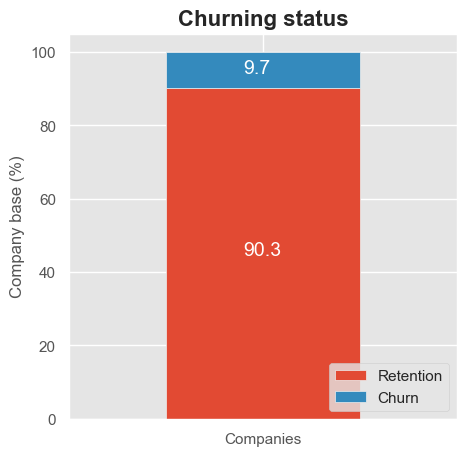

In [10]:
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

About 10% of the total customers have churned.

---
#### Feature Distribution and Churn Relationship Analysis
Explore the distribution of each variable and analyze how `churn` is associated with each feature

##### Consumption

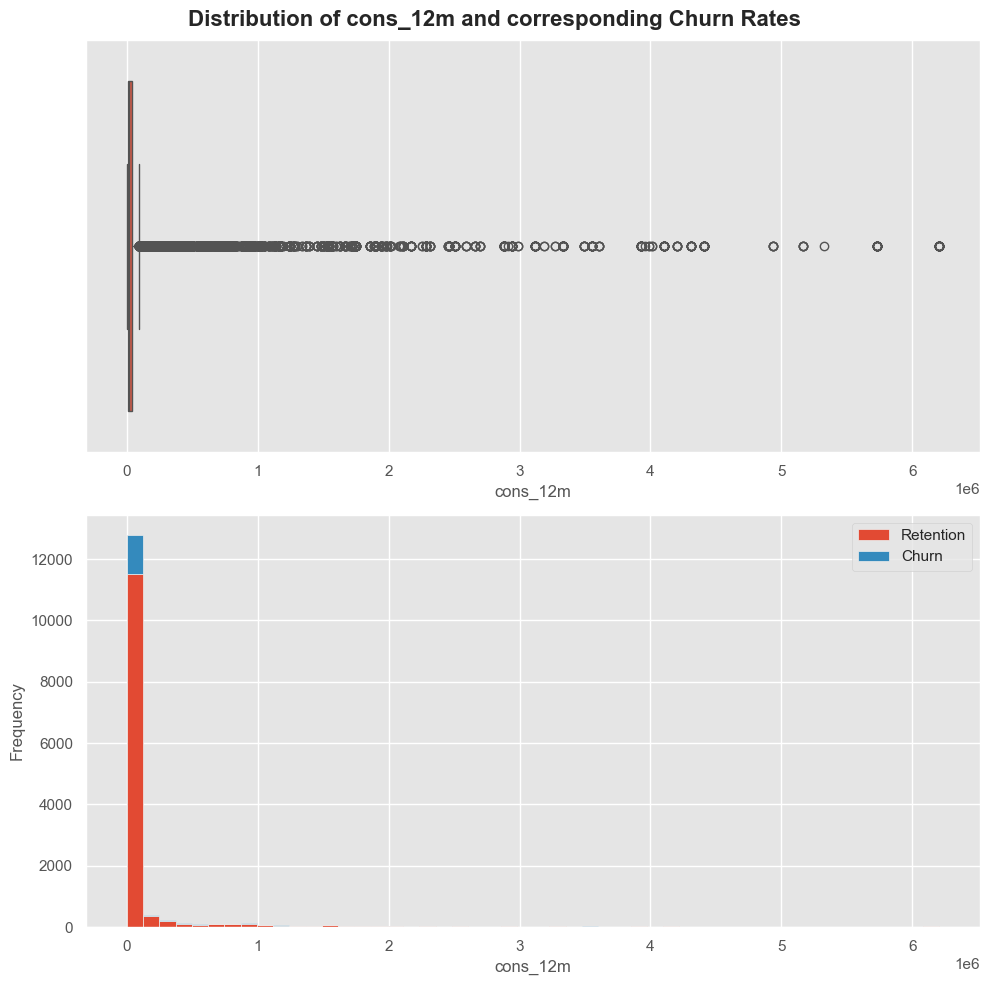

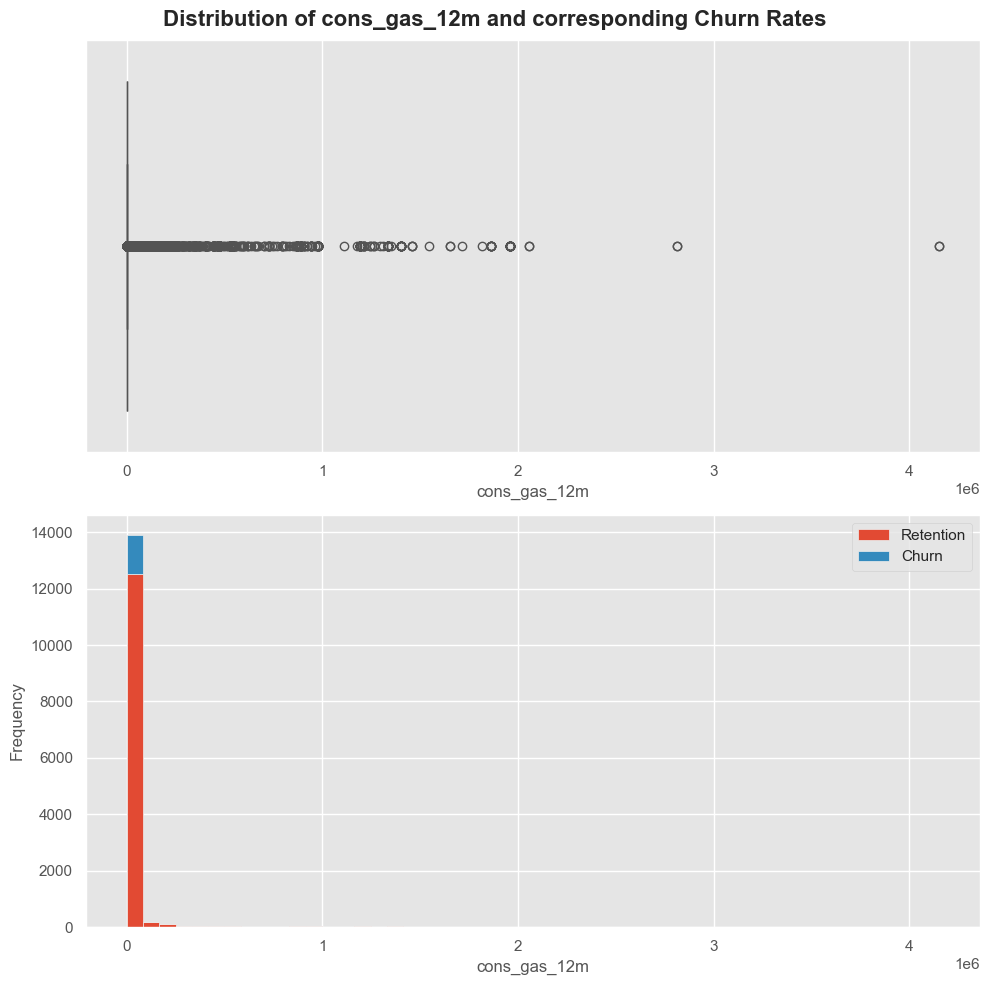

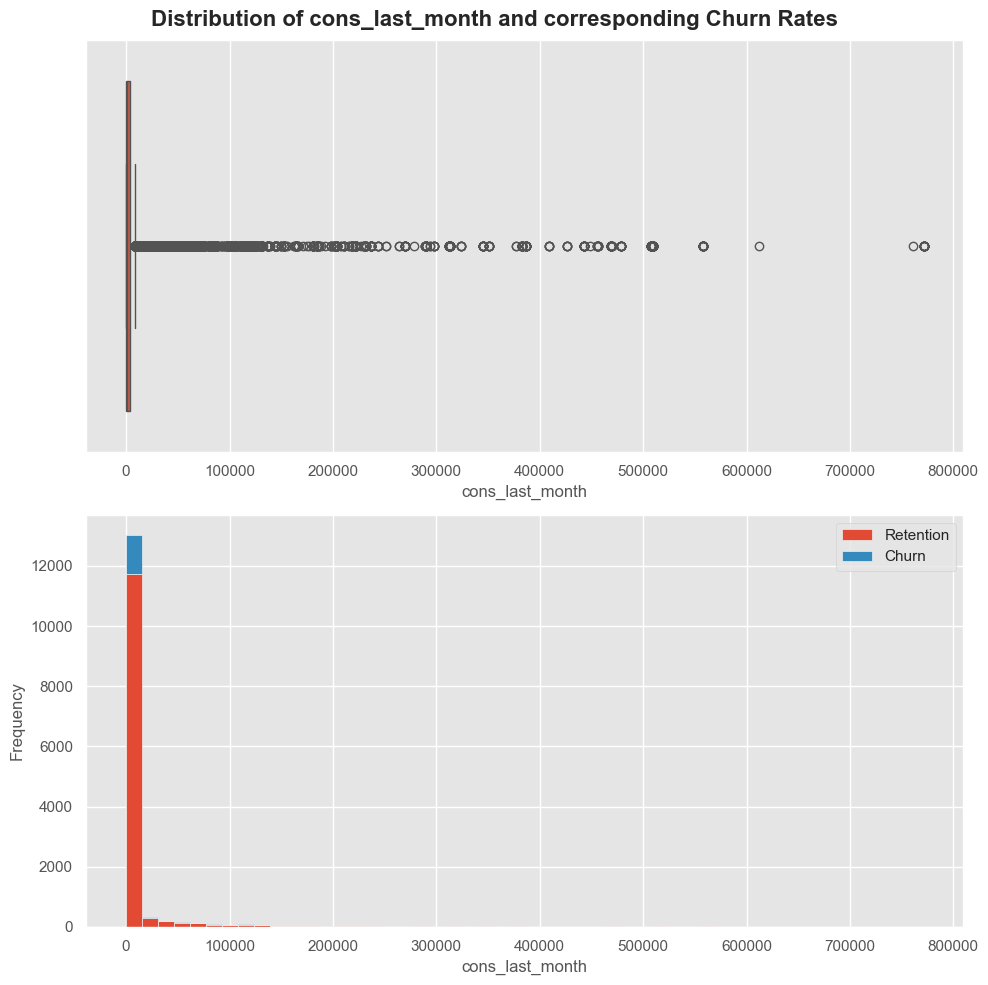

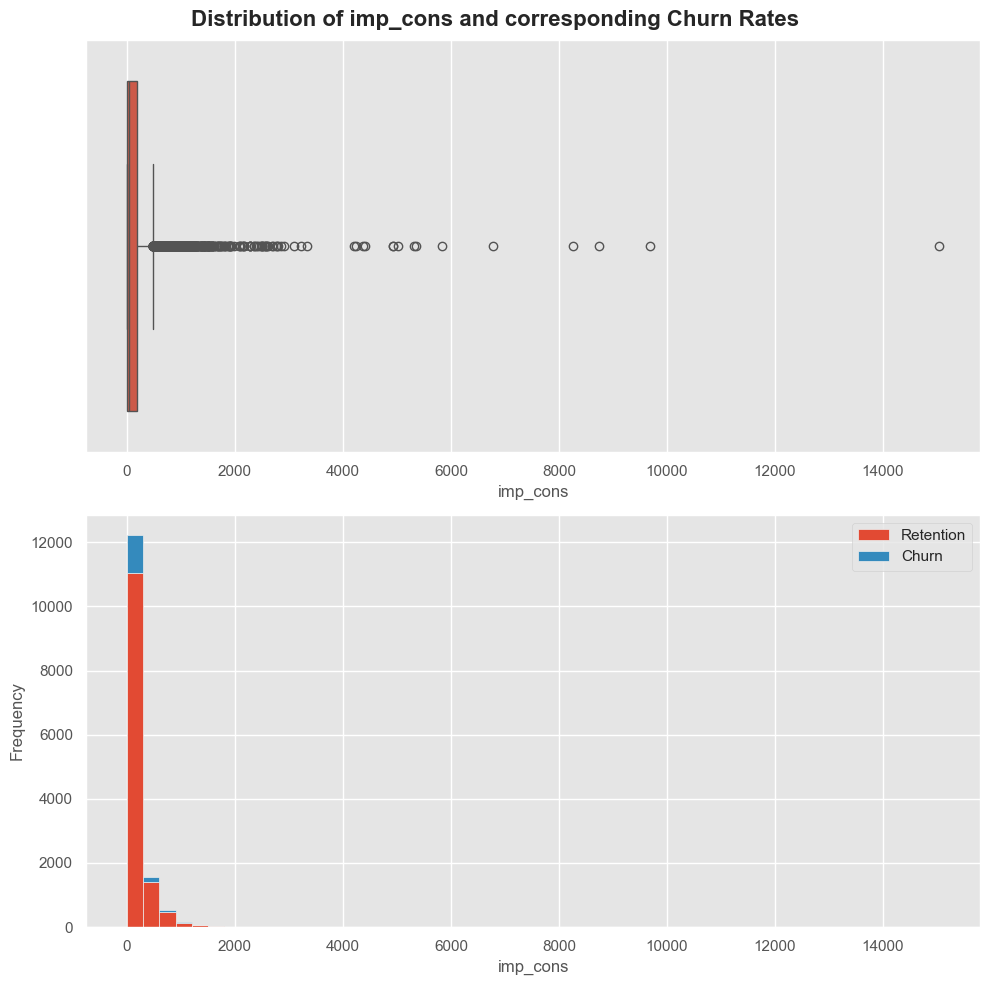

In [11]:
for col in ['cons_12m','cons_gas_12m','cons_last_month', 'imp_cons'] :

    plot_distribution_and_churn_rate(df = client_df,col = col,title = f'Distribution of {col} and corresponding Churn Rates' )

Insights:
- All of the examined variables show a strong right skew, indicating that a majority of values are clustered toward the lower end of the range.
- Clients with lower consumption levels tend to have a higher likelihood of churn, suggesting a potential link between lower engagement and churn risk.
- Since some clients do not subscribe to gas services, we should exclude these cases from the analysis before visualizing the distribution of cons_gas_12m to ensure a more accurate representation. 

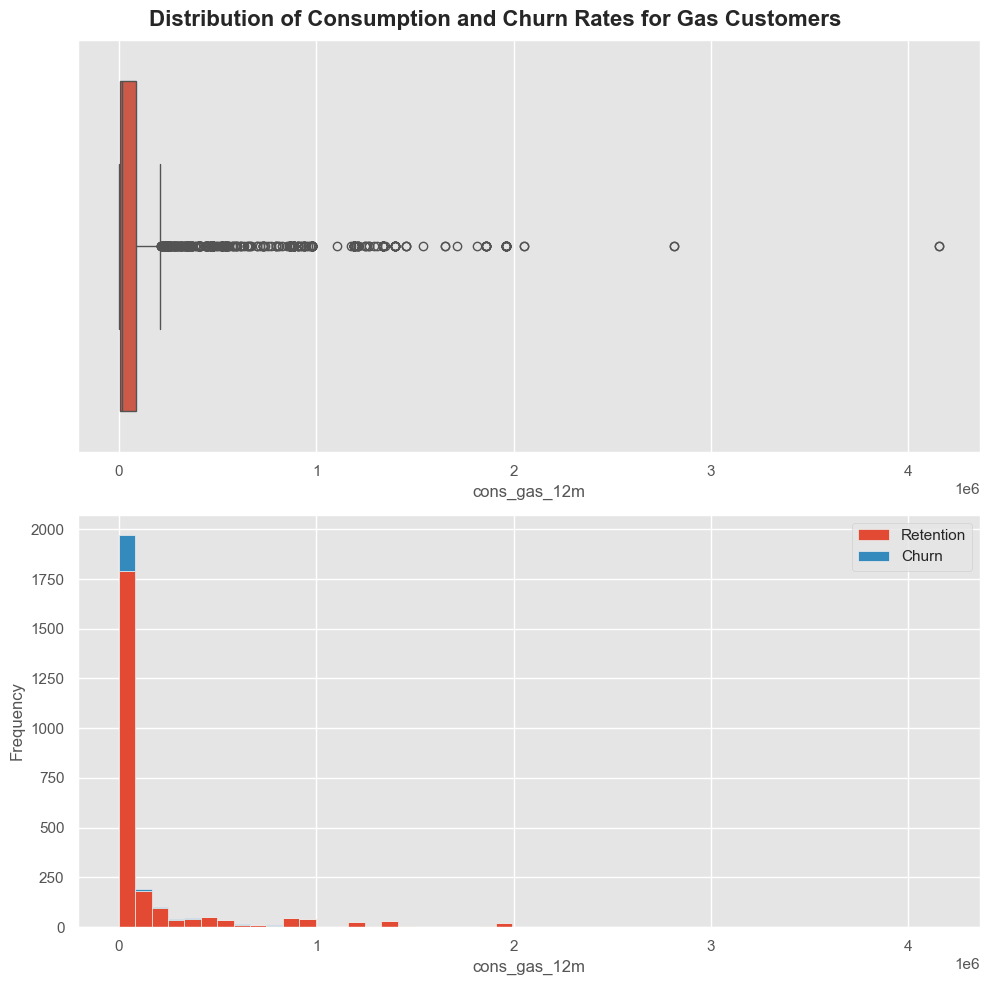

In [12]:
plot_distribution_and_churn_rate(df = client_df[client_df['has_gas'] == 't'],col = 'cons_gas_12m',title = 'Distribution of Consumption and Churn Rates for Gas Customers' )

The distribution of 'cons_gas_12m' looks more 'normal' after excluding the clients who didn't subscribe to gas service

---
##### Forecast

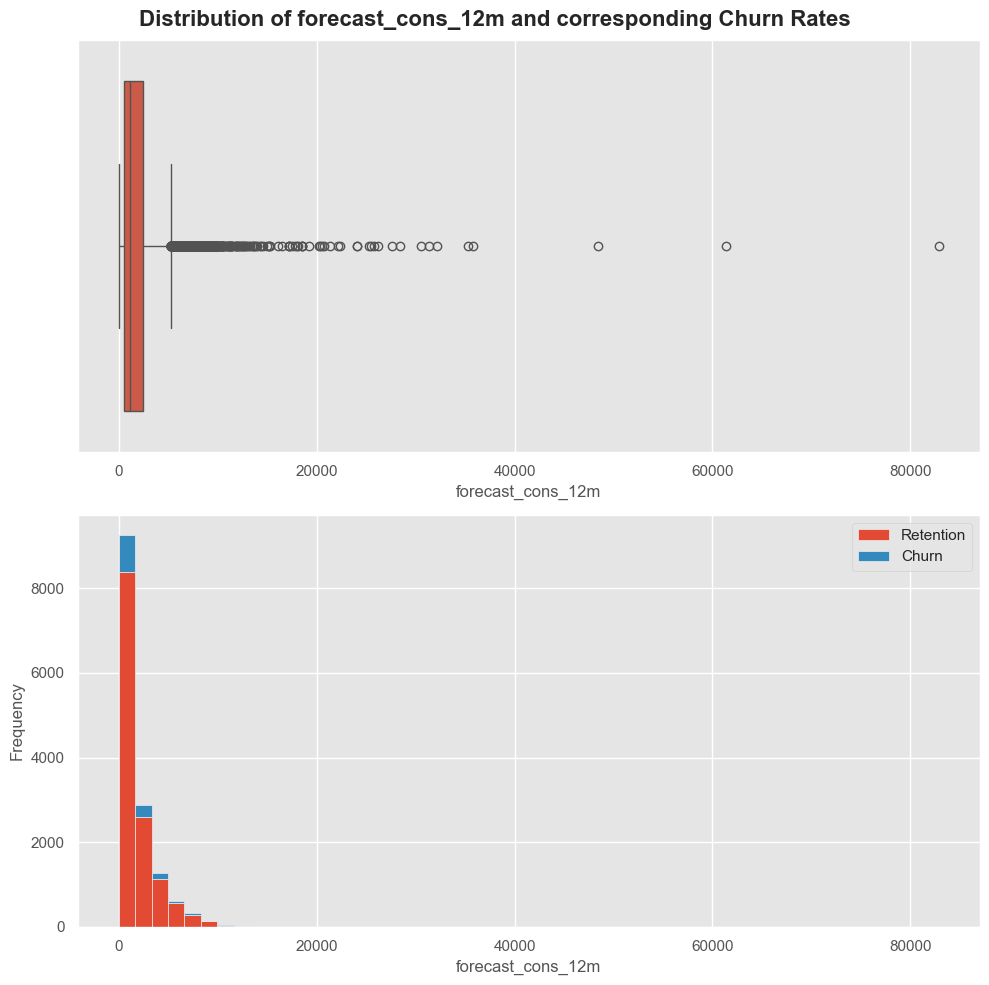

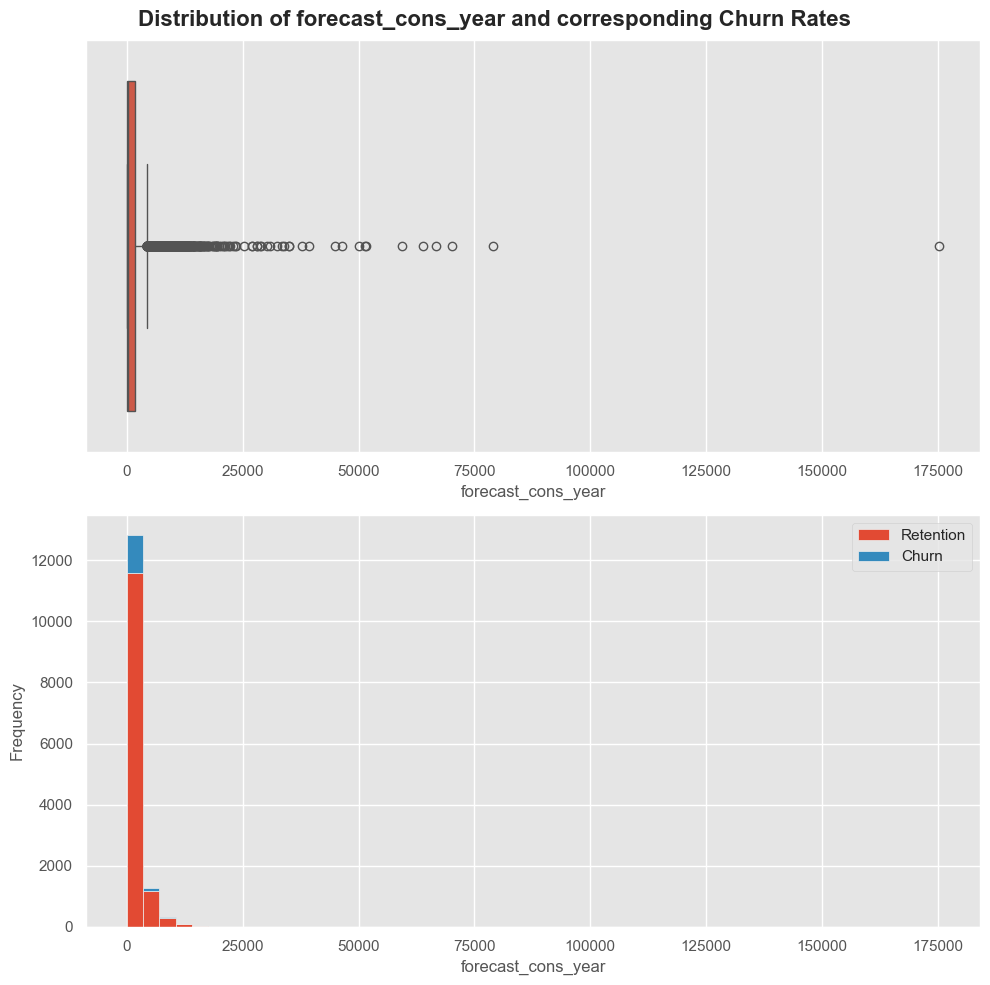

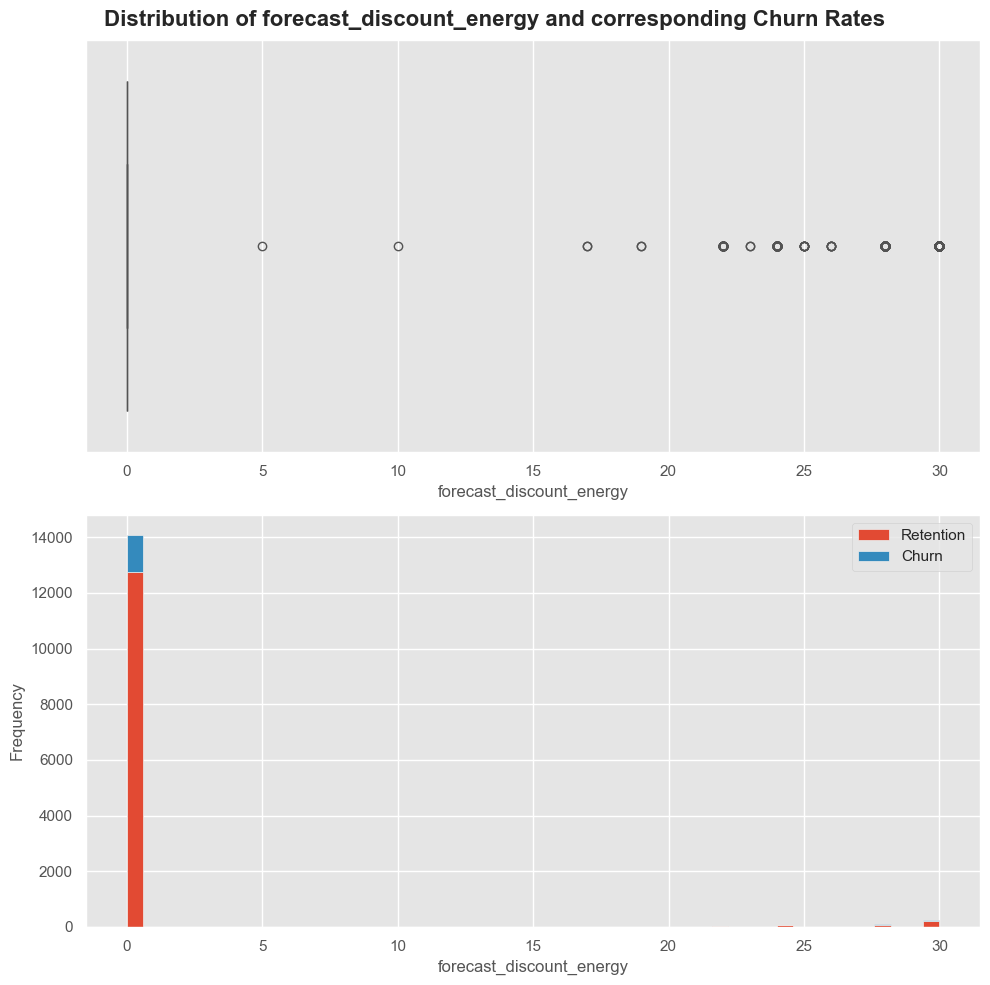

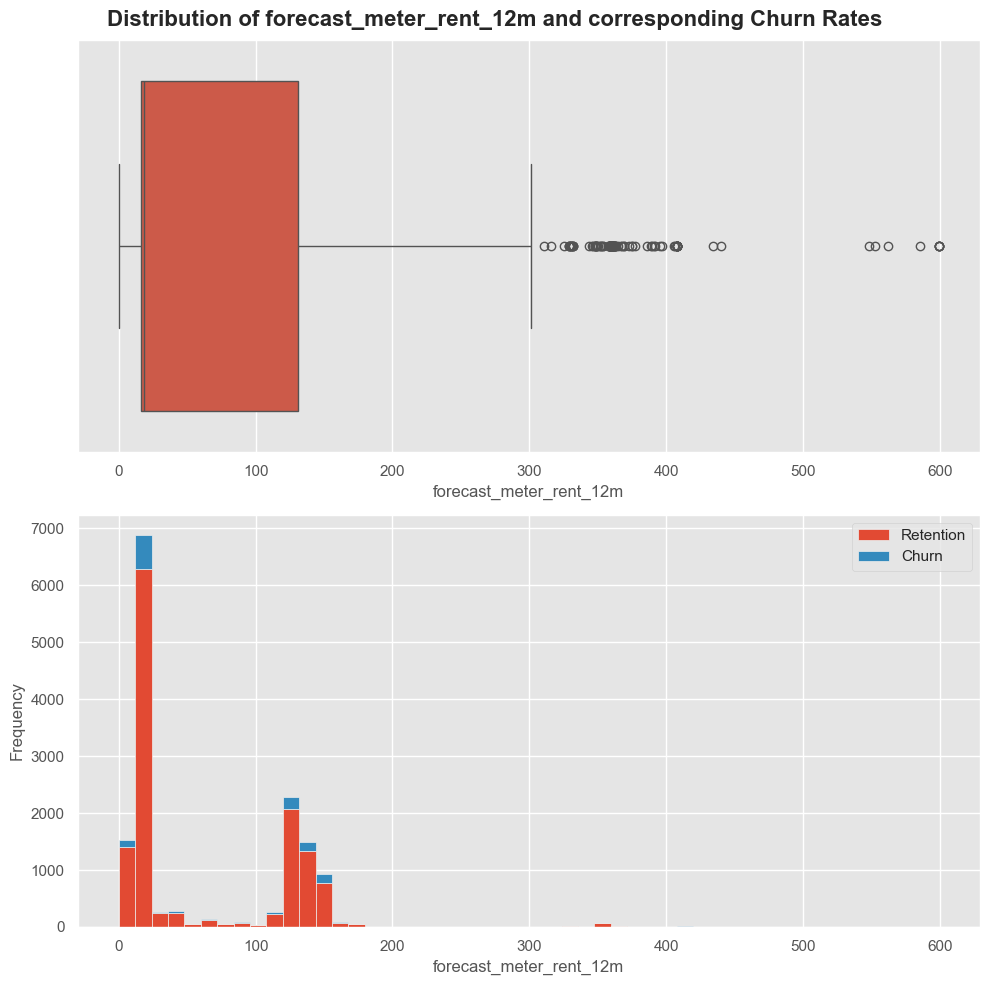

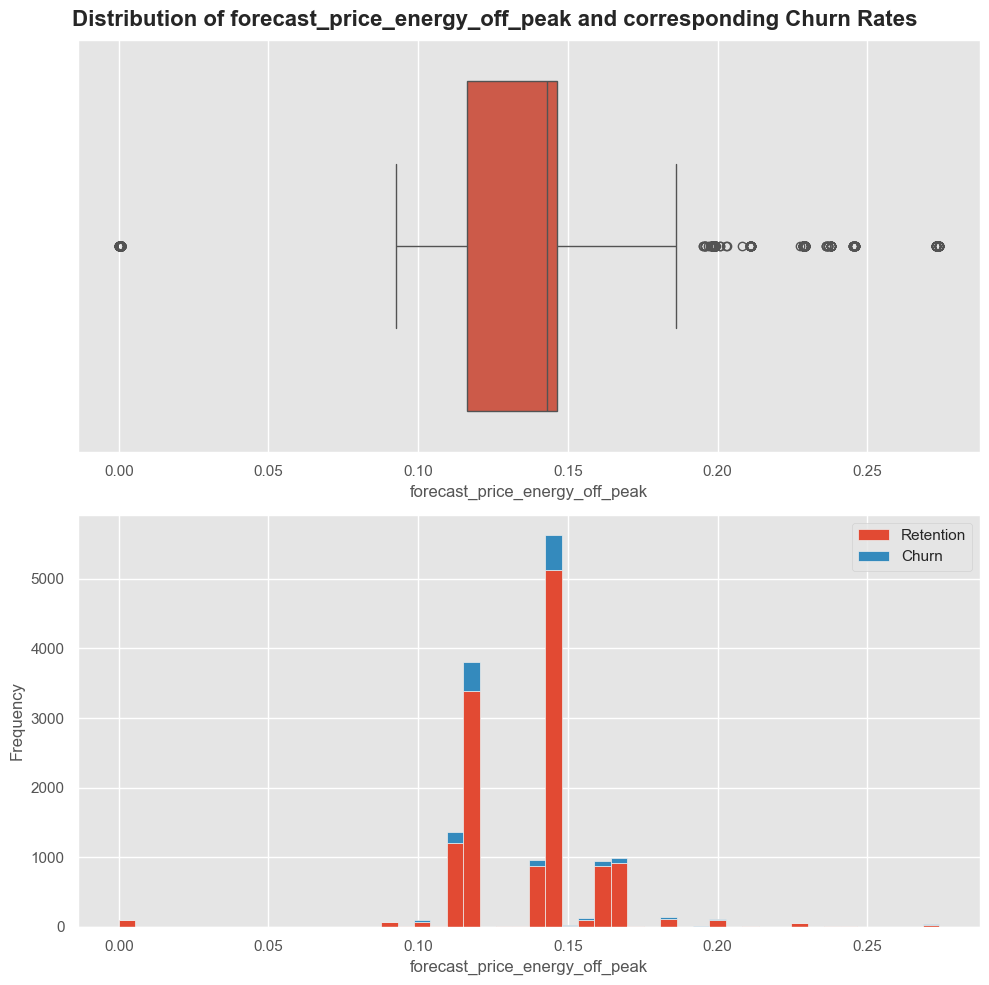

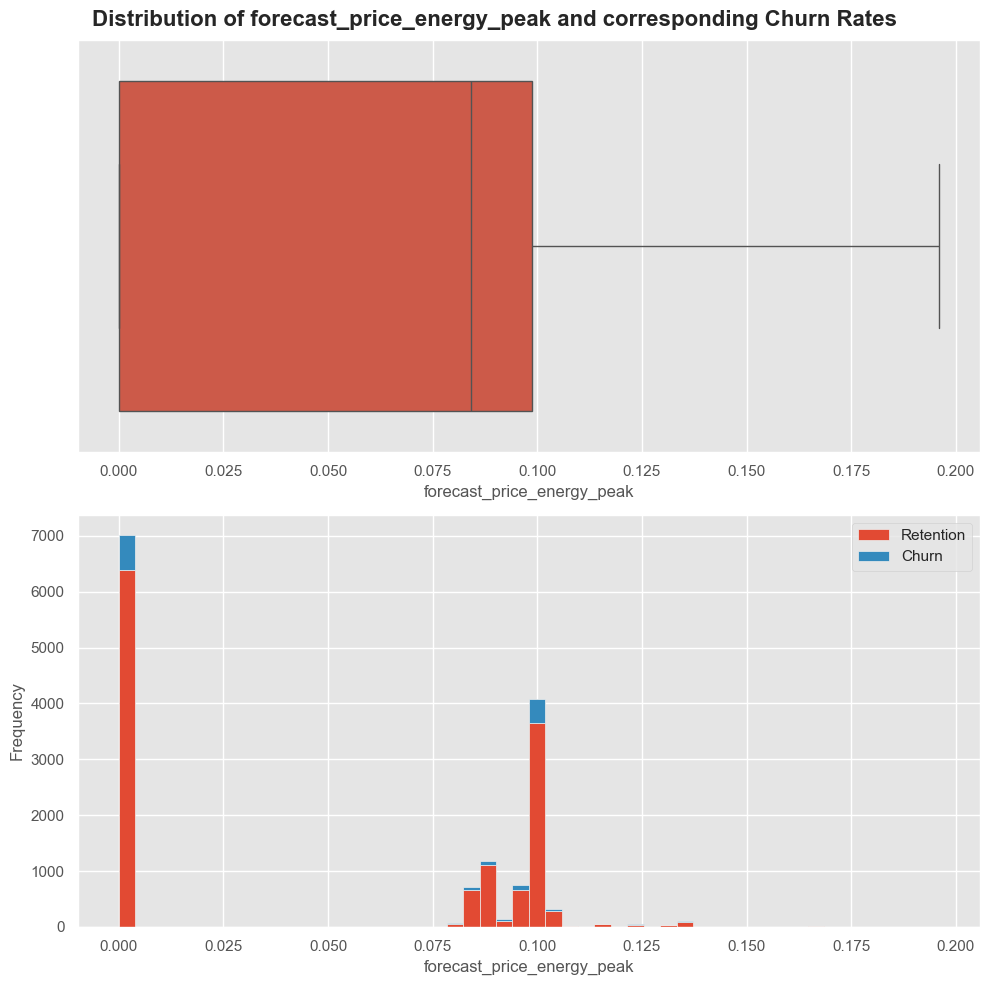

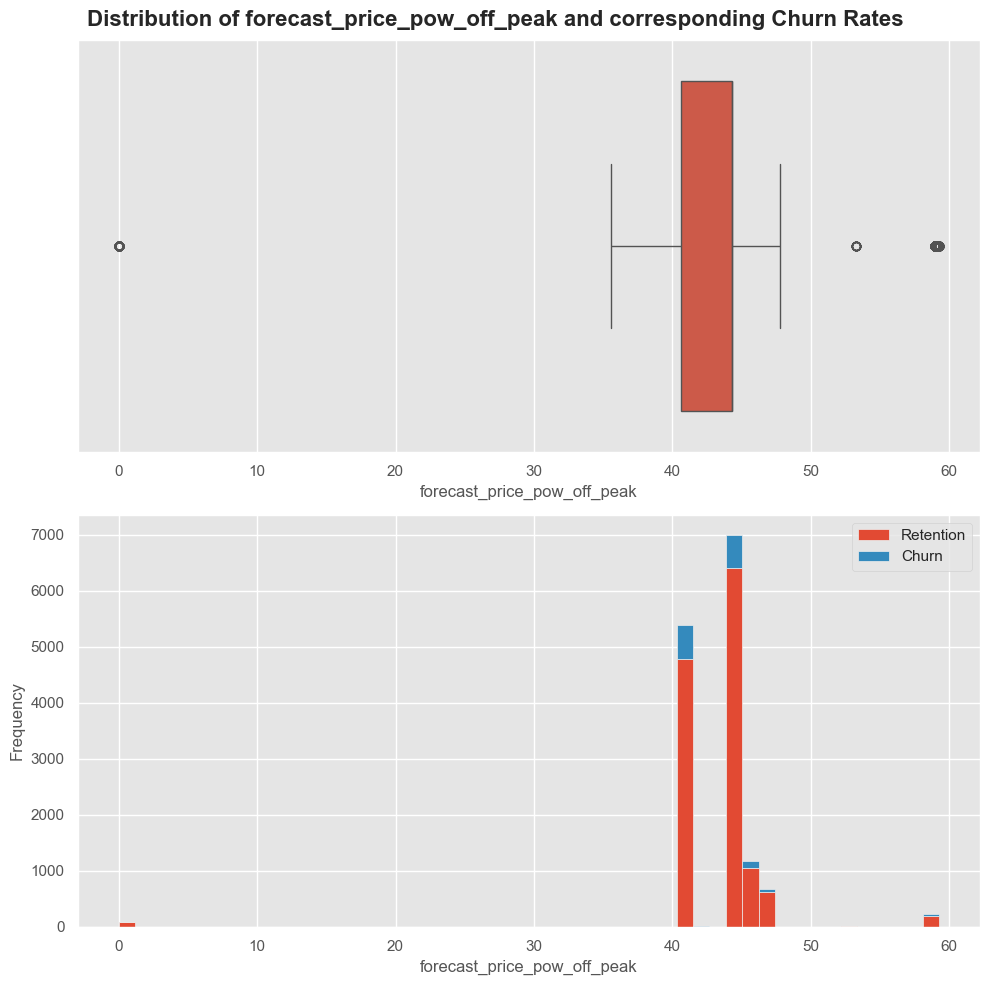

In [13]:
for col in client_df.columns :
    if ('forecast' in col) :
        plot_distribution_and_churn_rate(df = client_df,col = col,title = f'Distribution of {col} and corresponding Churn Rates' )

Similarly to the consumption plots, we can observe that a lot of the variables are highly positively skewed, creating a very long tail for the higher values. 

To address this skewness and improve model performance, we will apply transformations to normalize these distributions before inputting them into the model.

---
##### Margins

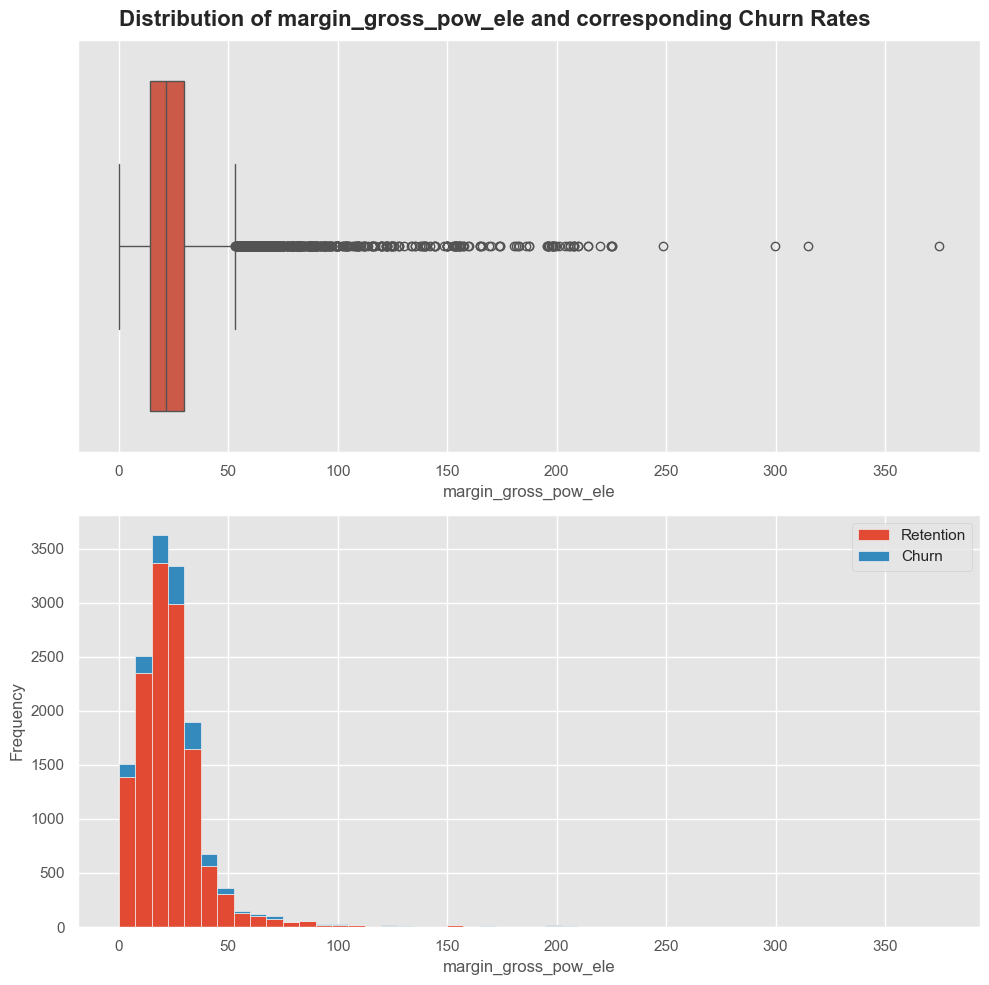

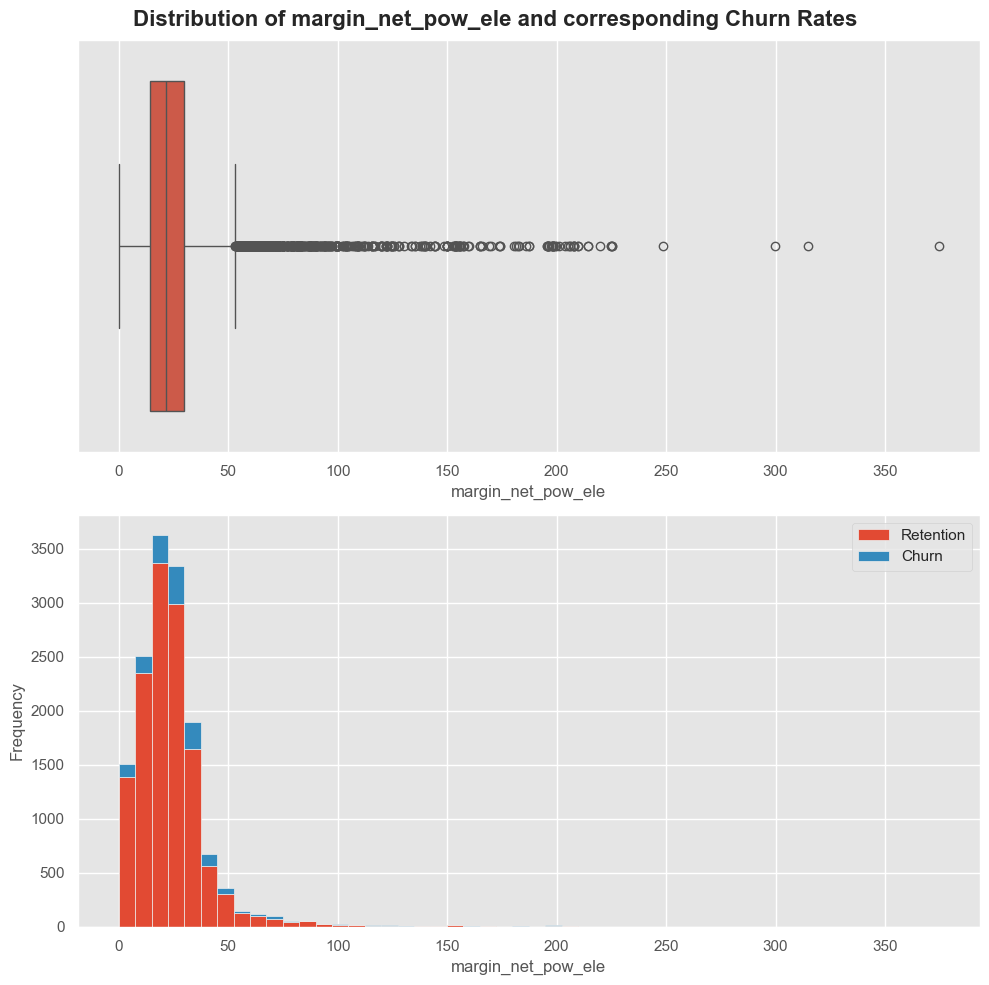

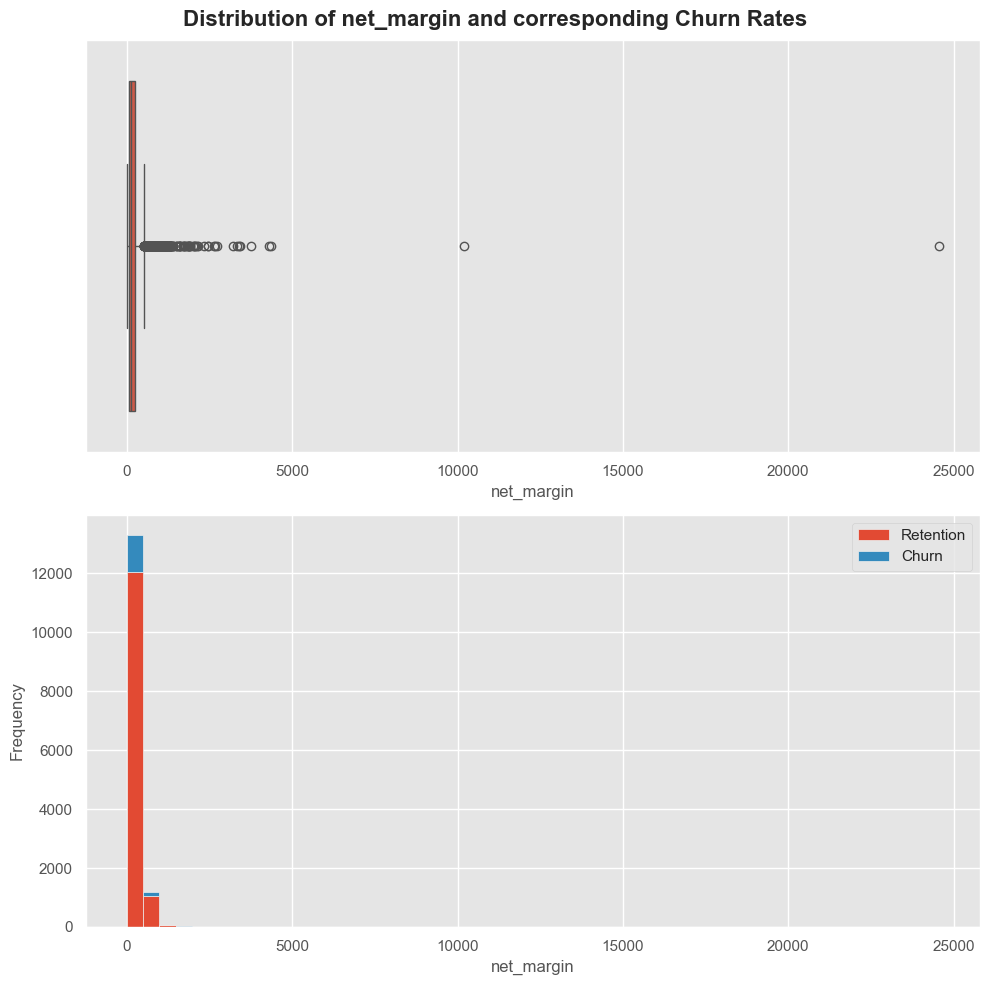

In [14]:
for col in client_df.columns :
    if ('margin' in col) :
        
        plot_distribution_and_churn_rate(df = client_df,col = col,title = f'Distribution of {col} and corresponding Churn Rates' )

Insights :
- margin_gross_pow_ele and margin_net_pow_ele may have limited predictive value for churn, as the conditional probability of churn does not show significant variation across different ranges of these variables.

---
##### Subscribed power

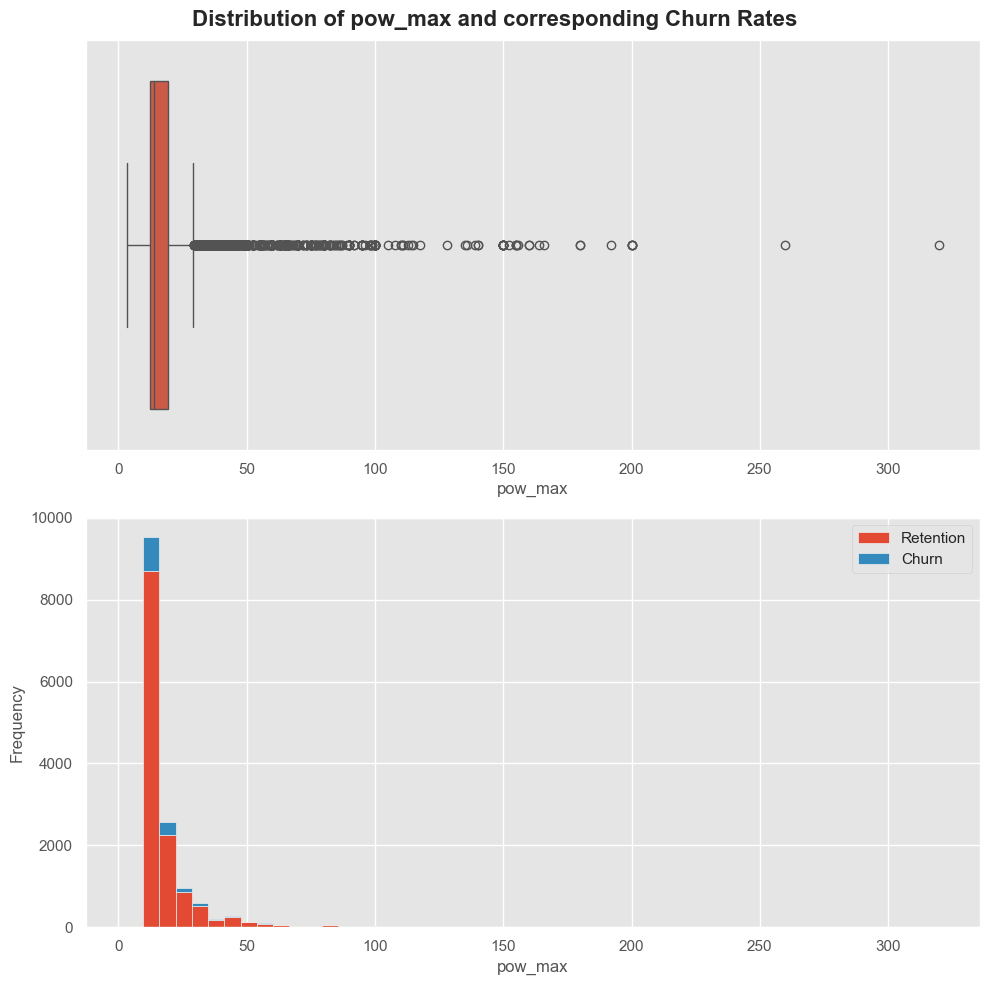

In [15]:
col = 'pow_max'
plot_distribution_and_churn_rate(df = client_df,col = col,title = f'Distribution of {col} and corresponding Churn Rates' )

Insights :
Clients with lower subscribed power tend to have a higher likelihood of churn, suggesting a potential link between lower engagement and churn risk.

---
##### Other Categorical Column

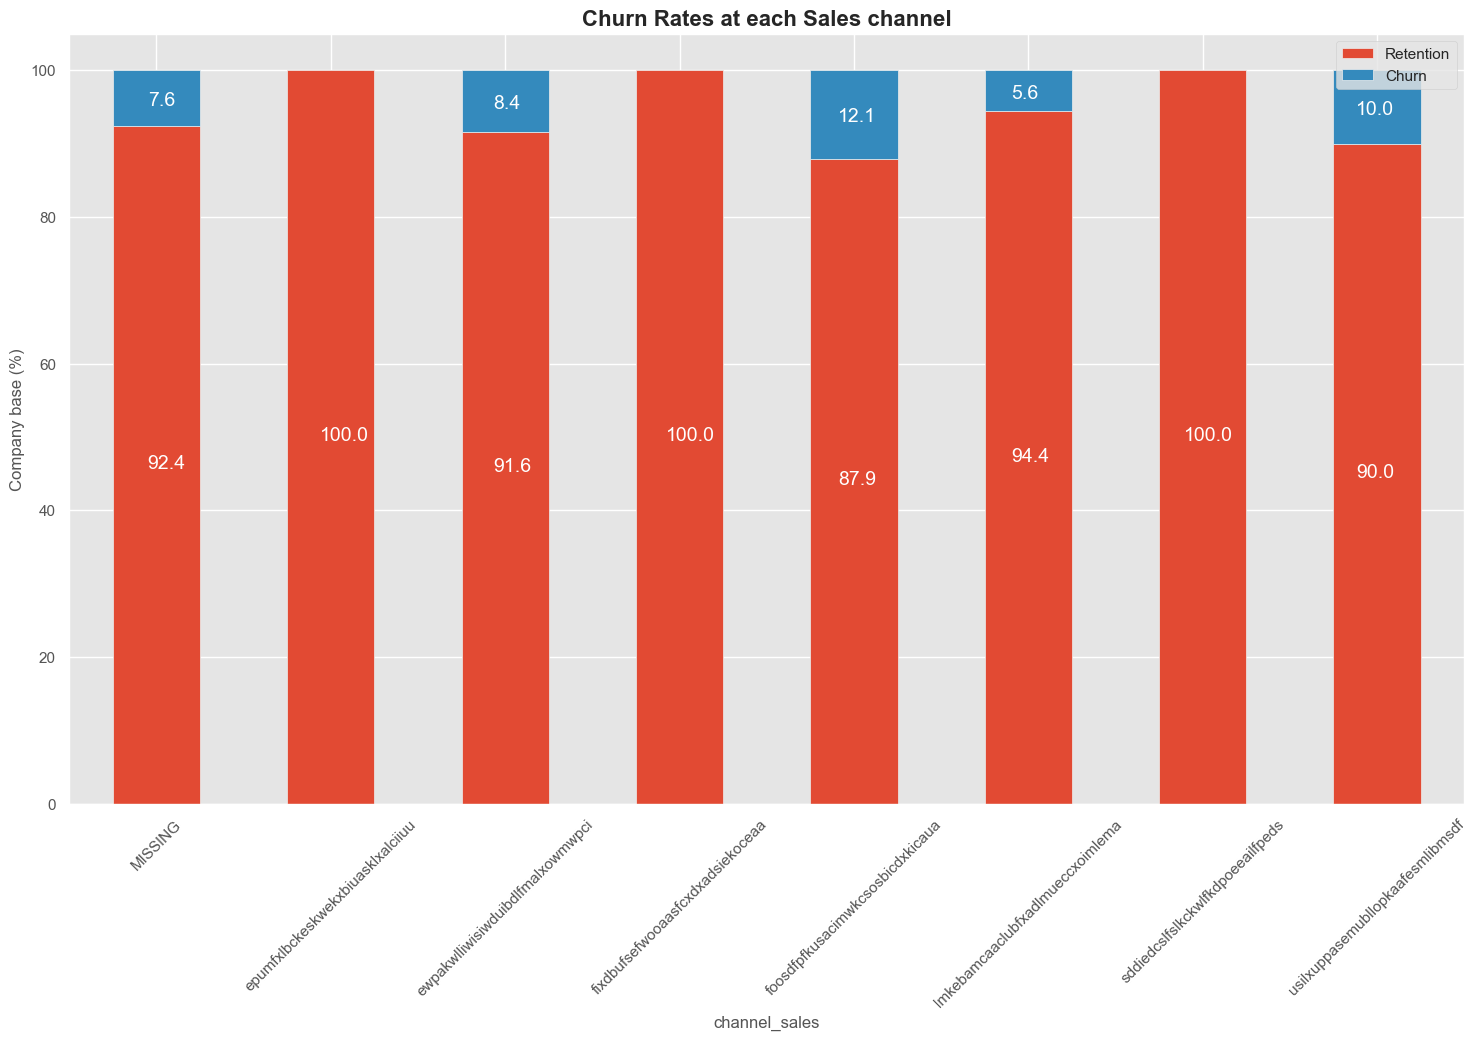

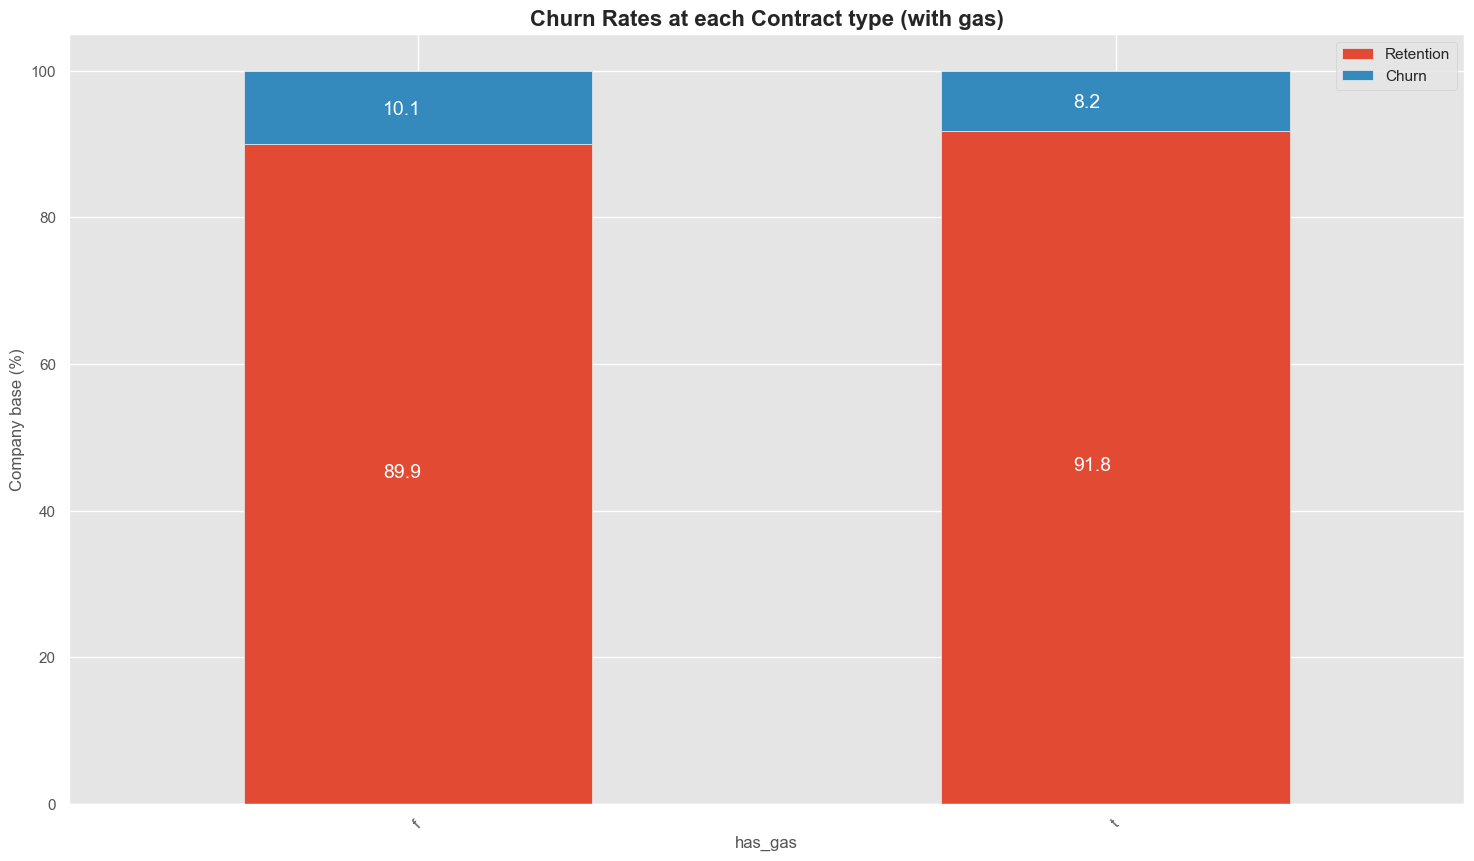

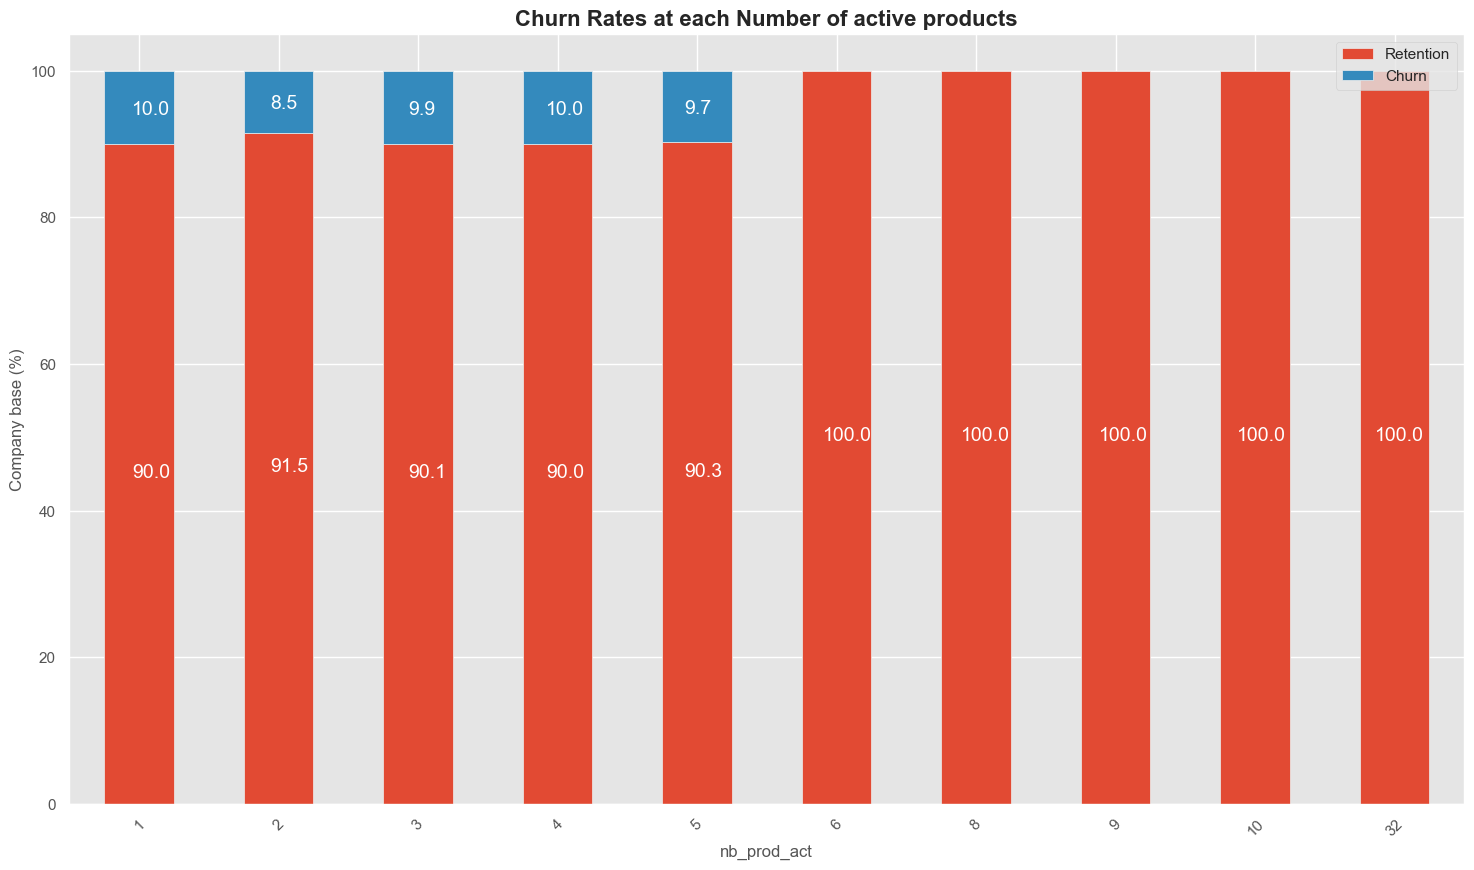

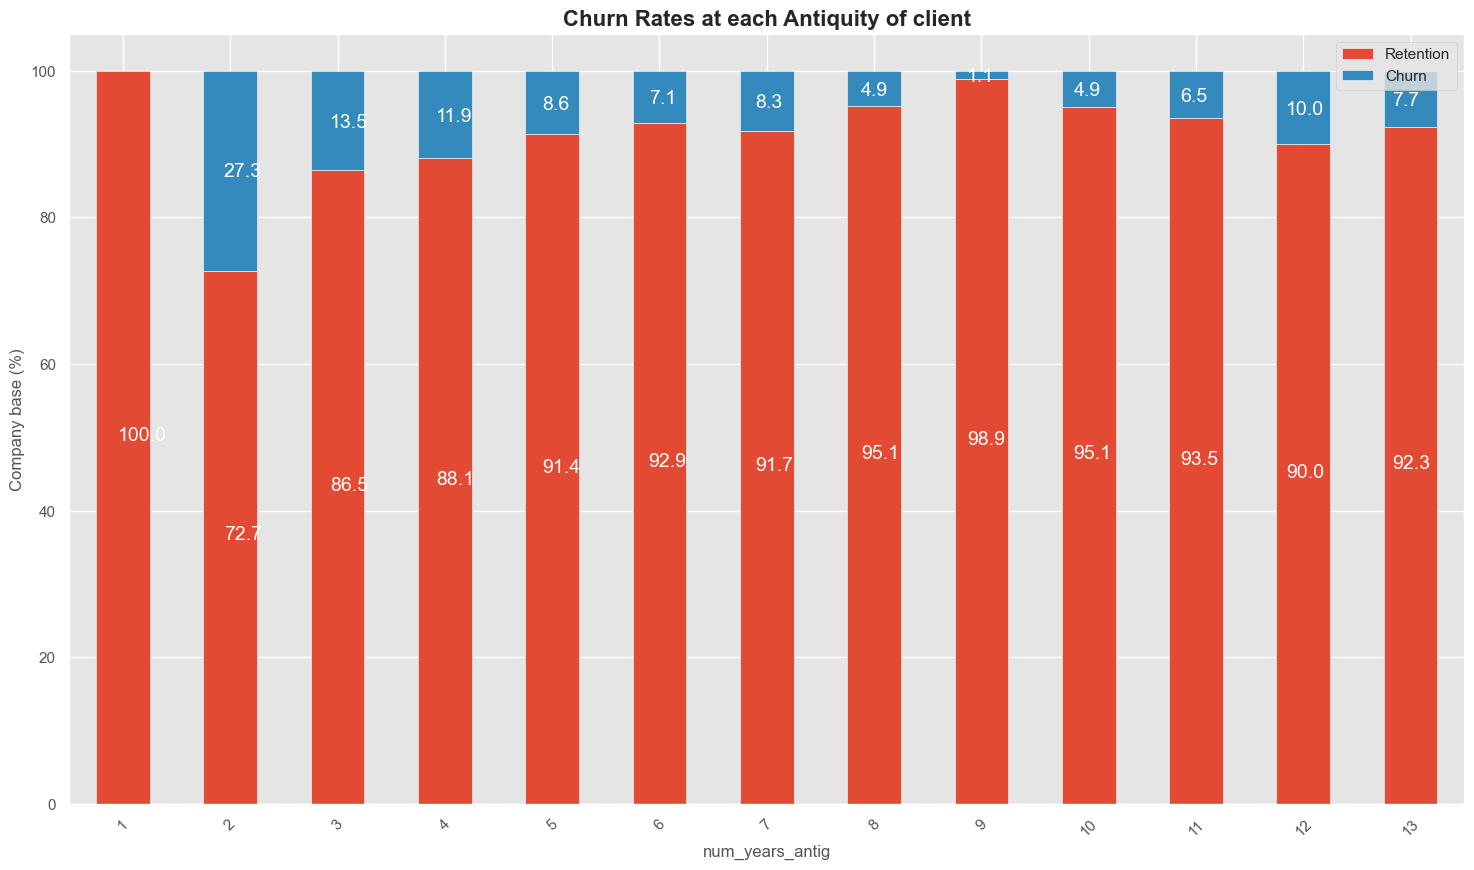

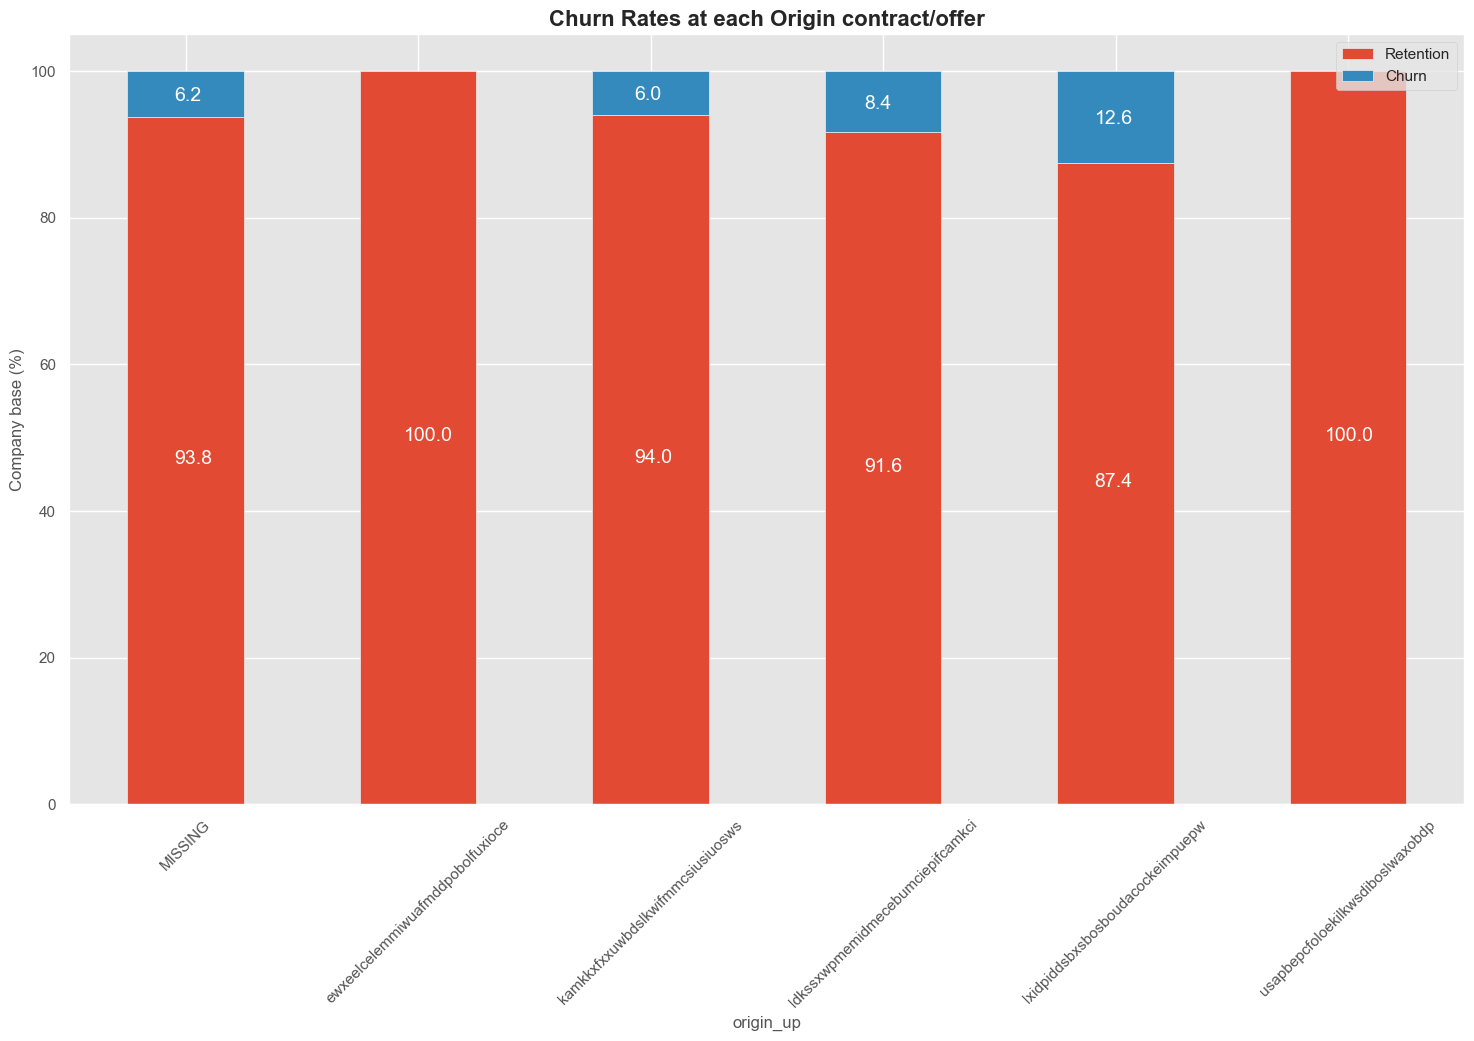

In [16]:
categorical_column = ['channel_sales','has_gas','nb_prod_act', 'num_years_antig', 'origin_up']
labels = ['Sales channel','Contract type (with gas)','Number of active products', 'Antiquity of client','Origin contract/offer']



for col,label in zip(categorical_column,labels) :
    count = client_df.groupby([col,"churn"])["id"].count().unstack(level=1)
    churn_percentage = (count.div(count.sum(axis=1), axis=0)*100)
    plot_stacked_bars(churn_percentage, 'Churn Rates at each ' + label,rot_=45)
    

Insights:
- The conditional probability of churn varies across different values of channel_sales and origin_up, suggesting that these variables could be useful predictors of churn.
- Gas service subscription status does not appear to influence the likelihood of churn.
- Clients with more than 5 active products show a lower likelihood of churning.
- Clients with an antiquity of 1 year are also less likely to churn.

---
#### Missing value

In [17]:
null_percentages = client_df.isnull().mean() * 100
result = pd.DataFrame(null_percentages, columns=['Null Percentage'])
result

,Null Percentage
id,0.0
channel_sales,0.0
cons_12m,0.0
cons_gas_12m,0.0
cons_last_month,0.0
date_activ,0.0
date_end,0.0
date_modif_prod,0.0
date_renewal,0.0
forecast_cons_12m,0.0


There are no missing values in client_df, so no missing value handling is necessary. 

However, the value "MISSING" appears in the columns channel_sales and origin_up, which may indicate unknown or unavailable data in these fields.

---
### price_df

#### Structure

In [18]:
price_df.head(20)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.000000,0.000000,44.266931,0.000000,0.000000
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.000000,0.000000,44.266931,0.000000,0.000000
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.000000,0.000000,44.266931,0.000000,0.000000
5,038af19179925da21a25619c5a24b745,2015-06-01,0.149626,0.000000,0.000000,44.266930,0.000000,0.000000
6,038af19179925da21a25619c5a24b745,2015-07-01,0.150321,0.000000,0.000000,44.444710,0.000000,0.000000
7,038af19179925da21a25619c5a24b745,2015-08-01,0.145859,0.000000,0.000000,44.444710,0.000000,0.000000
8,038af19179925da21a25619c5a24b745,2015-09-01,0.145859,0.000000,0.000000,44.444710,0.000000,0.000000
9,038af19179925da21a25619c5a24b745,2015-10-01,0.145859,0.000000,0.000000,44.444710,0.000000,0.000000


The price_df appears to be structured as panel data, where each client has their own pricing rate recorded for different months

In [19]:
price_df['price_date'].unique()

array(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
       '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
       '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
      dtype=object)

The time range for these prices spans from January 1, 2015, to December 1, 2015, covering the entire year of 2015. 


This indicates that price_df records the pricing information for each client throughout 2015

---
#### Time Series Analysis of Monthly Average Price Rate

In [20]:
avg_price = price_df.groupby(['price_date']).agg({'price_off_peak_var':'mean','price_peak_var' : 'mean', 'price_mid_peak_var' : 'mean', 'price_off_peak_fix' : 'mean', 'price_peak_fix' : 'mean', 'price_mid_peak_fix' : 'mean' })
#avg_price = avg_price.reset_index()
avg_price

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
price_date,,,,,,
2015-01-01,0.142568,0.054950,0.030333,43.226643,10.692921,6.455861
2015-02-01,0.142767,0.055053,0.030367,43.238161,10.673719,6.449016
2015-03-01,0.143104,0.055118,0.030396,43.254033,10.644489,6.430121
2015-04-01,0.143259,0.056035,0.030492,43.288439,10.647277,6.423156
2015-05-01,0.143534,0.055359,0.030393,43.315388,10.602453,6.390806
2015-06-01,0.143731,0.055255,0.029902,43.347320,10.415769,6.281304
2015-07-01,0.143683,0.055369,0.030636,43.345012,10.642236,6.421464
2015-08-01,0.137933,0.053605,0.030717,43.365366,10.661678,6.431518
2015-09-01,0.137933,0.053532,0.030606,43.351874,10.602979,6.391788


/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85565/2852487870.py:9: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axs[j].plot(avg_price.iloc[:,j],label= price_cols,color=color[j],linestyle='-')


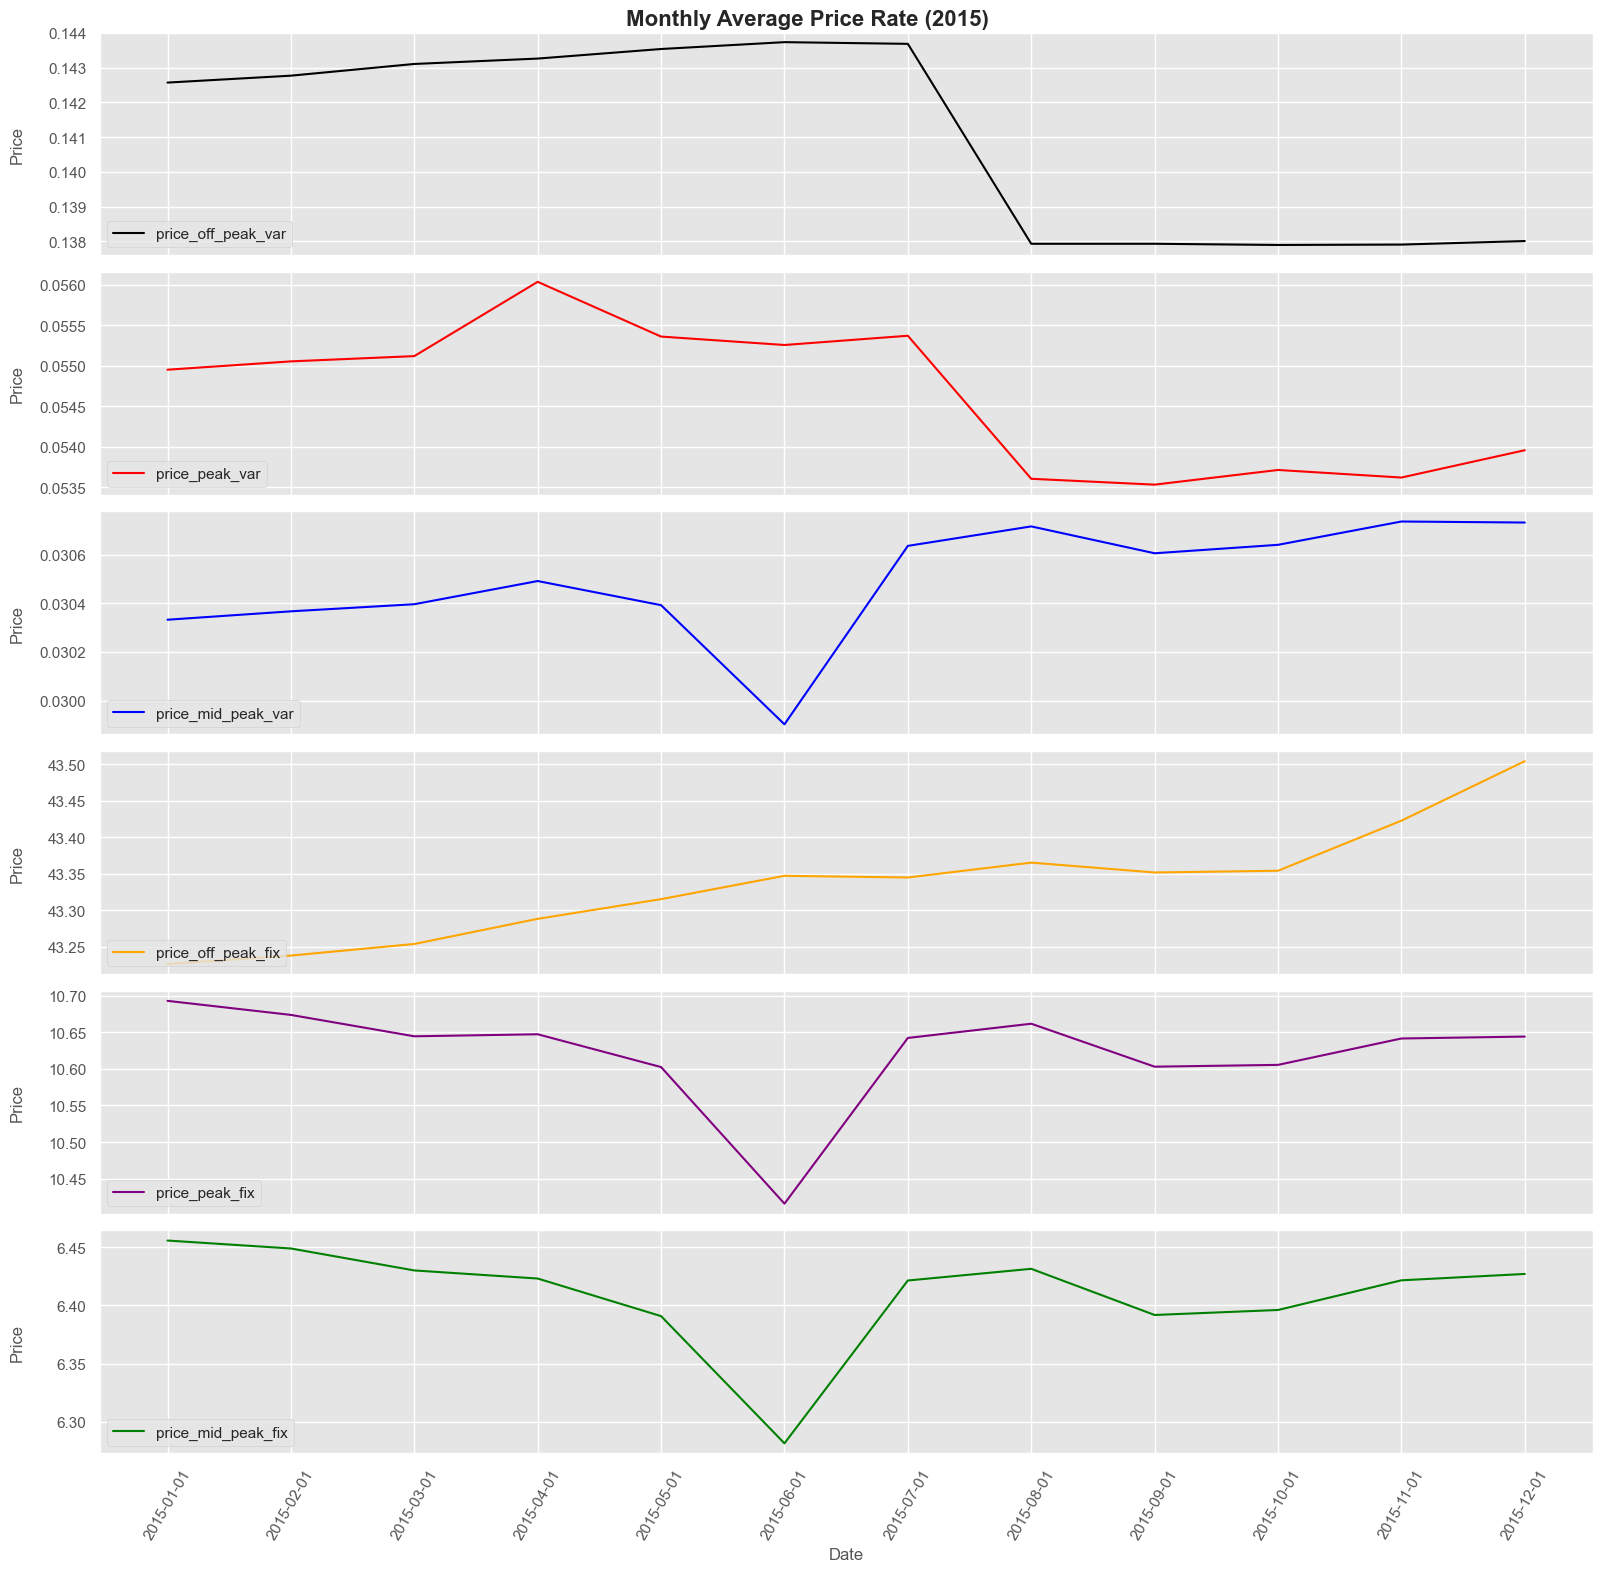

In [21]:
# Plot the stock prices of Apple, Facebook, and Amazon
price_cols = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var','price_off_peak_fix','price_peak_fix','price_mid_peak_fix']
color = ['black','red','blue','orange','purple','green']

fig, axs = plt.subplots(nrows=6,ncols=1,figsize=(16,16),sharex=True)


for j in range(len(price_cols)):
  axs[j].plot(avg_price.iloc[:,j],label= price_cols,color=color[j],linestyle='-')
  axs[j].legend([price_cols[j]],loc='lower left')
  axs[j].tick_params(axis='x',rotation=60)
  axs[j].set_ylabel('Price', labelpad=20) 

for ax in axs:
    ax.yaxis.set_label_coords(-0.05, 0.5)  # Adjust x and y coordinates to center the ylabel

plt.xlabel('Date')
#plt.ylabel('Price')
plt.suptitle('Monthly Average Price Rate (2015)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

Insights :

- The trends of price_peak_fix and price_mid_peak_fix are very similar, indicating a consistent pricing pattern for these periods.
- The price of electricity during off-peak periods has shown an upward trend over time, suggesting increasing costs during these hours.

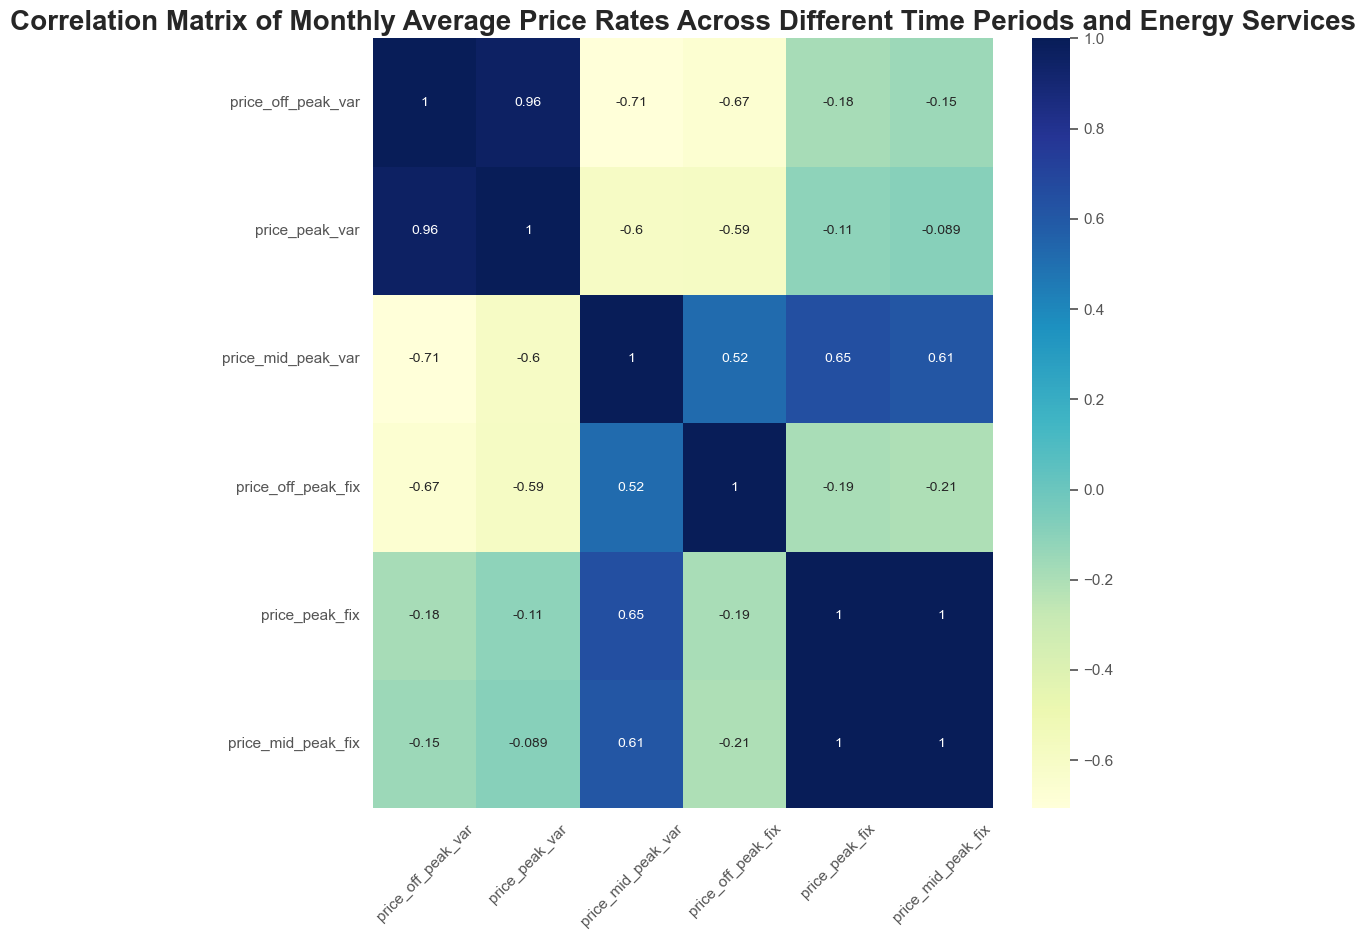

In [22]:
plt.figure(figsize=(10,10))
dataplot = sns.heatmap(avg_price.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.title('Correlation Matrix of Monthly Average Price Rates Across Different Time Periods and Energy Services', weight='bold',fontsize=20)
plt.xticks(rotation=45)
plt.show()

Insights :
- The correlation between price_peak_fix and price_mid_peak_fix is 0.96, indicating a strong linear relationship between these two pricing variables

---
#### Missing Value

In [23]:
null_percentages = price_df.isnull().mean() * 100
result = pd.DataFrame(null_percentages, columns=['Null Percentage'])
result

,Null Percentage
id,0.0
price_date,0.0
price_off_peak_var,0.0
price_peak_var,0.0
price_mid_peak_var,0.0
price_off_peak_fix,0.0
price_peak_fix,0.0
price_mid_peak_fix,0.0


There are no missing values in price_df, so no missing value handling is necessary. 